<a href="https://colab.research.google.com/github/hamza-dev-12/EmotionClassifer/blob/main/Finale_Emotion_Classifier_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install datasets
!pip install transformers

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset , DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
dataset = load_dataset('xed_en_fi','en_annotated')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/17528 [00:00<?, ? examples/s]

In [ ]:
data = pd.DataFrame(dataset['train'])

import pandas as pd



# Shuffle the DataFrame
data_shuffled = data.sample(frac=1)

# Reverse the shuffled DataFrame
data_shuffled_reversed = data_shuffled.iloc[::-1]

# Reset the index if needed
data_shuffled_reversed.reset_index(drop=True, inplace=True)



data_shuffled_reversed.head(5)

,sentence,labels
0,Are you quite sure you'd be able to use it in ...,[7]
1,I tried to make it easier for you .,[6]
2,I absolutely do not wan na hear about it .,[1]
3,"Well , that's easy .",[5]
4,Who sent you ? - Fuck you .,[1]


In [ ]:
attributes = [ 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 170, 174, 176, 177, 179, 182, 183, 184, 185, 188, 192, 193, 194, 196, 198, 202, 204, 207, 209, 216, 218, 221, 222, 228, 229, 251, 261, 281, 290, 299]


<BarContainer object of 193 artists>

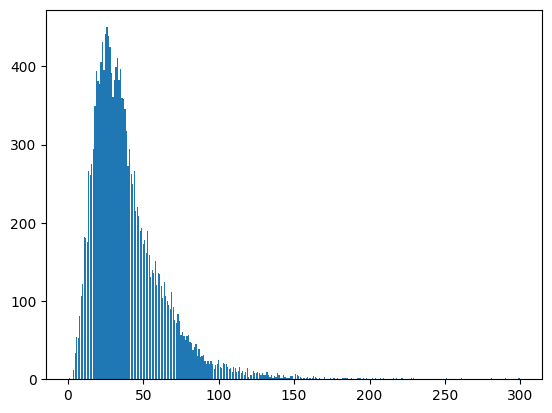

In [ ]:
sentences_length = [len(sentence) for sentence in data['sentence']]
lens = list(set(sentences_length))
print(lens)
sen_count = pd.Series(sentences_length).value_counts().sort_index()
plt.bar(lens,sen_count.values)

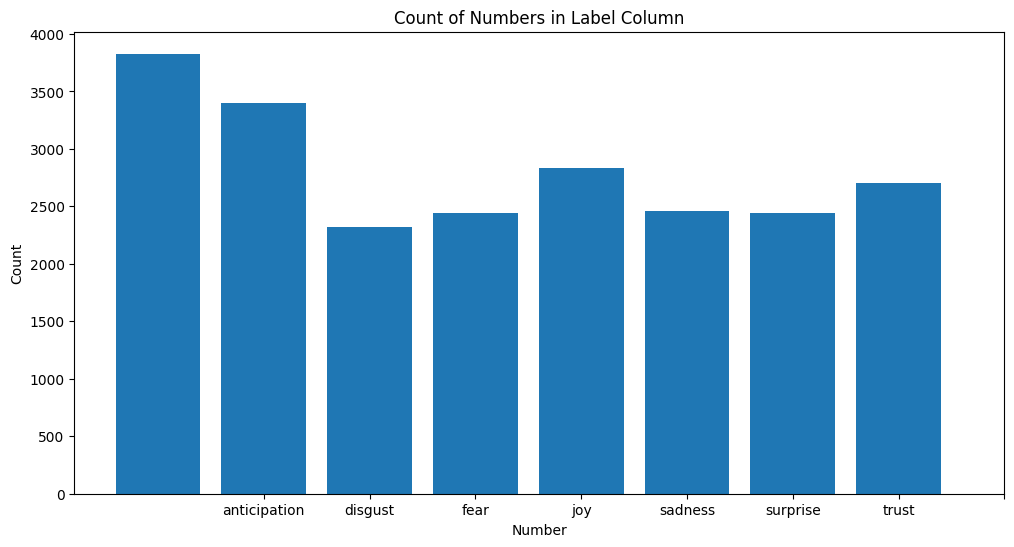

In [ ]:
# Flatten the list of lists in the 'label' column
labels_flat = [item for sublist in data['labels'] for item in sublist]

# Count the occurrences of each number
label_counts = pd.Series(labels_flat).value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(attributes, label_counts.values)
plt.xlabel('Number')
plt.ylabel('Count')
plt.title('Count of Numbers in Label Column')
plt.xticks(range(1,9))  # Assuming the range is 1-8
plt.show()

In [ ]:
class Em_Dataset(Dataset):
  def __init__(self,x,y,tokenizer):
    self.x = x
    self.y = self.one_hot_encoding(y)
    self.tokenizer = tokenizer

  def one_hot_encoding(self,labels):
    one_hot_encoded = []
    for label in labels:
      one_hot = [0] * 8
      for emotion in label:
        one_hot[emotion - 1] = 1
      one_hot_encoded.append(one_hot)
    return one_hot_encoded

  def __len__(self):
    assert len(self.x) == len(self.y)
    return len(self.x)

  def __getitem__(self,index):
    sentence = self.x.iloc[index]  # Use iloc to access rows by integer index
    labels = torch.FloatTensor(self.y[index])
    tokens = self.tokenizer(sentence,
                            add_special_tokens=True,
                            return_tensors = 'pt',
                            padding = 'max_length',
                            truncation = True,
                            max_length = 128,
                            return_attention_mask = True
                            )
    #2d list to 1d
    return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}

**Train Test Split**

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(data['sentence'],data['labels'],test_size=0.3,train_size=0.7)

In [ ]:
print(type(y_train))

<class 'pandas.core.series.Series'>


**Importing Model And Tokenizer**

In [ ]:
from transformers import AutoTokenizer
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
train_dataset = Em_Dataset(x_train,y_train,tokenizer)
test_dataset = Em_Dataset(x_test,y_test,tokenizer)

In [ ]:
train_dataLoader = DataLoader(dataset=train_dataset,batch_size=32,num_workers=2,shuffle=True)
test_dataLoader = DataLoader(dataset=test_dataset,batch_size=32,num_workers=2,shuffle=True)

In [ ]:
print(len(train_dataset))

12269


In [ ]:
from torch import nn
import torch.nn.functional as F
from transformers import AutoModel

class Emotion_Sentence_Classifier(nn.Module):

  def __init__(self,config : dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'],return_dict=True)
    self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size,self.pretrained_model.config.hidden_size)
    self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size,self.config['n_labels'])

    #initilizing weights
    torch.nn.init.xavier_uniform(self.classifier.weight)

    #loss function
    self.loss_func = nn.BCEWithLogitsLoss(reduction = 'mean')
    #BCE is the combination of cross entropy followed by the sigmoid function

    #droupout for model to avoid to be overfitted
    self.dropout = nn.Dropout()

    # for param in self.pretrained_model.parameters():
    #         param.requires_grad = False

  def forward(self,input_ids,attention_mask,labels=None):
  #roberta layer
    output = self.pretrained_model(input_ids = input_ids,attention_mask = attention_mask)
    #print('output before avg-pooling: ',output)
    # batch size * sequence_length * hidden layer size
    pooled_output = torch.mean(output.last_hidden_state,1)
    #batch size * hidden layer size
    #print('after avg pooling : ',pooled_output)
    #my nn layer
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output) # relu activation function
    logits = self.classifier(pooled_output)
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1,self.config['n_labels']),labels.view(-1,self.config['n_labels']))
    return loss , logits




In [ ]:
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 128,
    'lr': 1.5e-6,
    'n_epochs': 10
}

model = Emotion_Sentence_Classifier(config)

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

<ipython-input-16-951eabb8092f>:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.classifier.weight)


In [ ]:
total_training_samples = len(x_train)
print(total_training_samples)

12269


**Reloading Pre-Train-Model**

In [ ]:
import torch
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Define your model architecture (same as the one you used to train the model)
# For example:
# model = YourModel()
learning_rate = 0.0001
epoch = 2
# Load the model's state dictionary


##<Team Member> Uncomment this for your path

#model_state_dict = torch.load( "/content/drive/MyDrive/checkpoints/Em_model_12_1.5e-6lr.pth")

model_state_dict = torch.load('/content/drive/MyDrive/Emotion_Classifier/Em2_model_20_1.5e-06lr.pth')

# Load the state dictionary into the model
model.load_state_dict(model_state_dict)

# Set the model to train mode'
model.to('cuda')
model.train()


Emotion_Sentence_Classifier(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

**Training Loop**

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),config['lr'])

criterion = nn.BCELoss()
epoch_loss = []

model.to('cuda')
model.train()

for epoch in range(10):
    Loss = []
    for i, ku in enumerate(train_dataLoader):
      print(i,')',end=' ')
      #forward propagation
      loss , logits = model(ku['input_ids'].to('cuda'),ku['attention_mask'].to('cuda'),ku['labels'].to('cuda'))

      #back propagate
      loss.backward()

      #update weights
      optimizer.step()

      #clear gradients
      optimizer.zero_grad()

      Loss.append(loss.item())
      print(loss , end = '\n')
    epoch_loss.append(sum(Loss)/len(Loss))

<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}


0 ) tensor(0.3084, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 ) tensor(0.3372, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
2 ) tensor(0.2898, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
3 ) tensor(0.2292, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
4 ) tensor(0.3131, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
5 ) tensor(0.2977, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
6 ) tensor(0.3588, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
7 ) tensor(0.3248, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
8 ) tensor(0.3089, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
9 ) tensor(0.3013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
10 ) tensor(0.3085, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogit

<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}


0 ) tensor(0.3206, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 ) tensor(0.3208, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
2 ) tensor(0.3543, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
3 ) tensor(0.3437, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
4 ) tensor(0.2560, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
5 ) tensor(0.3574, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
6 ) tensor(0.2551, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
7 ) tensor(0.2913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
8 ) tensor(0.3351, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
9 ) tensor(0.2814, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
10 ) tensor(0.3184, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogit

<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}


0 ) tensor(0.2387, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 ) tensor(0.3286, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
2 ) tensor(0.3127, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
3 ) tensor(0.2788, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
4 ) tensor(0.3059, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
5 ) tensor(0.2737, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
6 ) tensor(0.2662, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
7 ) tensor(0.3021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
8 ) tensor(0.2998, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
9 ) tensor(0.2465, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
10 ) tensor(0.3180, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogit

<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}


0 ) tensor(0.3421, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 ) tensor(0.3618, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
2 ) tensor(0.3166, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
3 ) tensor(0.3841, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
4 ) tensor(0.2637, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
5 ) tensor(0.2728, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
6 ) tensor(0.3288, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
7 ) tensor(0.2925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
8 ) tensor(0.3485, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
9 ) tensor(0.3387, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
10 ) tensor(0.3321, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogit

<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}


0 ) tensor(0.2672, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 ) tensor(0.3312, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
2 ) tensor(0.2380, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
3 ) tensor(0.3528, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
4 ) tensor(0.3392, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
5 ) tensor(0.2898, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
6 ) tensor(0.3825, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
7 ) tensor(0.3312, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
8 ) tensor(0.2766, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
9 ) tensor(0.2878, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
10 ) tensor(0.3089, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogit

<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}


0 ) tensor(0.2864, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 ) tensor(0.2716, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
2 ) tensor(0.3623, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
3 ) tensor(0.2747, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
4 ) tensor(0.2927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
5 ) tensor(0.2675, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
6 ) tensor(0.2519, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
7 ) tensor(0.3181, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
8 ) tensor(0.2911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
9 ) tensor(0.2478, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
10 ) tensor(0.3152, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogit

<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}


0 ) tensor(0.2902, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 ) tensor(0.2863, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
2 ) tensor(0.3441, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
3 ) tensor(0.3187, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
4 ) tensor(0.3079, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
5 ) tensor(0.3087, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
6 ) tensor(0.2610, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
7 ) tensor(0.3144, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
8 ) tensor(0.2747, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
9 ) tensor(0.2675, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
10 ) tensor(0.2291, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogit

<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}


0 ) tensor(0.2787, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 ) tensor(0.2498, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
2 ) tensor(0.2743, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
3 ) tensor(0.2933, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
4 ) tensor(0.2468, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
5 ) tensor(0.2795, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
6 ) tensor(0.2829, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
7 ) tensor(0.2694, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
8 ) tensor(0.2515, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
9 ) tensor(0.2727, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
10 ) tensor(0.2996, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogit

<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}


0 ) tensor(0.2876, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 ) tensor(0.2636, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
2 ) tensor(0.3065, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
3 ) tensor(0.2651, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
4 ) tensor(0.2508, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
5 ) tensor(0.3126, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
6 ) tensor(0.3294, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
7 ) tensor(0.2639, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
8 ) tensor(0.3795, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
9 ) tensor(0.2784, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
10 ) tensor(0.2644, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogit

<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-8-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}


0 ) tensor(0.2878, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 ) tensor(0.2973, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
2 ) tensor(0.2420, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
3 ) tensor(0.3634, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
4 ) tensor(0.2649, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
5 ) tensor(0.2487, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
6 ) tensor(0.2194, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
7 ) tensor(0.2603, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
8 ) tensor(0.2791, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
9 ) tensor(0.2791, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
10 ) tensor(0.2594, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogit

**Saving Model**

In [ ]:
import torch

previous_epoch = 10

epoch = 10 + previous_epoch



# Assuming 'model' is your PyTorch model
# torch.save(model.state_dict(), 'Em_model_{}_{}.pth'.format(epoch,config['lr']))
torch.save(model.state_dict(), 'Em2_model_{}_{}.pth'.format(epoch,config['lr']))


**Saving To Drive**

In [ ]:
import shutil

# Source path (where your model.pth file is located in Colab)
source_path =  'Em2_model_{}_{}.pth'.format(epoch,config['lr'])

# Destination path in Google Drive
destination_path = "/content/drive/MyDrive/Emotion_Classifier/Em2_model_{}_{}lr.pth".format(epoch,config['lr'])

# Copy the file
shutil.copyfile(source_path, destination_path)


'/content/drive/MyDrive/Emotion_Classifier/Em2_model_20_1.5e-06lr.pth'

**Accuracy After some Training**

In [ ]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
number_of_correct_predictions = 0.0



with torch.no_grad():
  for epoch in range(1):
      for i, ku in enumerate(test_dataLoader):
        print(i,end=' ')
        _ , logits = model(ku['input_ids'].to('cuda'),ku['attention_mask'].to('cuda'),ku['labels'].to('cuda'))
        predicted_emotions = torch.where(F.sigmoid(logits) > 0.5,torch.tensor(1),torch.tensor(0))

        correct_predictions = torch.eq(predicted_emotions,ku['labels'].to('cuda'))
        number_of_correct_predictions += torch.sum(correct_predictions).item()




print('correct predicitons  : ',number_of_correct_predictions)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-9-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-9-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : to

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 correct predicitons  :  37018.0


In [ ]:
print('correct predictions : ',number_of_correct_predictions)
print('total outcomes',len(x_test) * 8)
print('Accuracy',round((number_of_correct_predictions)/(len(x_test) * 8) * 100,2),'%' )



correct predictions :  37018.0
total outcomes 42072
Accuracy 87.99 %


In [ ]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
true_positive_predictions = 0.0
total_positive_predictions = 0.0

with torch.no_grad():
    for epoch in range(1):
        for i, ku in enumerate(test_dataLoader):
            print(i, end=' ')
            _, logits = model(ku['input_ids'].to('cuda'), ku['attention_mask'].to('cuda'), ku['labels'].to('cuda'))
            predicted_emotions = torch.where(F.sigmoid(logits) > 0.5, torch.tensor(1), torch.tensor(0))

            true_positive_predictions += torch.sum(predicted_emotions * ku['labels'].to('cuda')).item()
            total_positive_predictions += torch.sum(predicted_emotions).item()

precision = true_positive_predictions / total_positive_predictions if total_positive_predictions > 0 else 0

print('Precision: ', precision)


**Inference**

In [ ]:
model.eval()

Emotion_Sentence_Classifier(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [ ]:
import torch
import torch.nn.functional as F

def inference(sentence):
  x = tokenizer(sentence)
  with torch.no_grad():
    _ , output = model(torch.tensor([x['input_ids']]).to('cuda'),torch.tensor([x['attention_mask']]).to('cuda'),None)
    prediction = torch.where(F.sigmoid(output) > 0.5,torch.tensor(1),torch.tensor(0))
    em = []
    for index , el in enumerate(prediction[0]):
      if el == 1:
        em.append(attributes[index])
    return em

In [ ]:
print(inference('I dont want to talk about it!'))
print(inference('this is the best day of my life'))
print(inference('what are you doing?'))
print(inference('Its impossible. David'))
print(inference('that is a great thing'))


['anger', 'disgust']
[]
['anger', 'disgust']
['sadness']
['joy']


In [ ]:
print(inference('Get Lost!'))
print(inference('I do not want to live anymore. I hate this world!'))
print(inference('It was lovely meeting you!'))

[]
['sadness']
['joy']


In [ ]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
number_of_correct_predictions = 0.0

TP = 0
TN = 0
FP = 0
FN = 0

with torch.no_grad():
  for epoch in range(1):
      for i, ku in enumerate(test_dataLoader):
        print(i,end=' ')
        _ , logits = model(ku['input_ids'].to('cuda'),ku['attention_mask'].to('cuda'),ku['labels'].to('cuda'))
        predicted_emotions = torch.where(F.sigmoid(logits) > 0.5,torch.tensor(1),torch.tensor(0))

        correct_predictions = torch.eq(predicted_emotions,ku['labels'].to('cuda'))
        number_of_correct_predictions += torch.sum(correct_predictions).item()

        TP = ((predicted_emotions == 1) & (ku['labels'].to('cuda') == 1)).sum().item()
        TN = ((predicted_emotions == 0) & (ku['labels'].to('cuda') == 0)).sum().item()
        FP = ((predicted_emotions == 1) & (ku['labels'].to('cuda') == 0)).sum().item()
        FN = ((predicted_emotions == 0) & (ku['labels'].to('cuda') == 1)).sum().item()






<ipython-input-9-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}
<ipython-input-9-0085e8b0ea2f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids' : torch.tensor(tokens.input_ids.flatten()),'attention_mask' : torch.tensor(tokens.attention_mask.flatten()),'labels' : torch.tensor(labels)}


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 

In [ ]:
precision = TP / (TP + FP)
print('precision',precision)

precision 0.5555555555555556


In [ ]:
recall = TP / (TP + FN)

print('recall',recall)

recall 0.4166666666666667
